<a href="https://colab.research.google.com/github/WillKWL/Project-KaggleCreditCard/blob/main/Kaggle_3_test_set_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from google.colab import drive, files
import os
from joblib import load

import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
import copy
from datetime import datetime
from wordcloud import WordCloud

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
import sklearn
sklearn.set_config(display='diagram')

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Project-KaggleCreditCard')

Mounted at /content/drive


# Load environment
- load the following to evaluate model performance on test set:
  - custom clases,
  - functions, 
  - models dumped after hyperparameter tuning ,
  - test set

## Custom classes and functions
- data preparation pipeline before fitting estimator

In [3]:
# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

## Models after hyperparameter tuning

In [8]:
tuned_models = {}
time_list = []
time_diff = []
# specify regex pattern to load latest models
match_pattern = '_AP_class_balanced_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "Adaboost Extree Class Balanced loaded", latest)

extree Adaboost Extree Class Balanced loaded 20221023_045326
xgb Adaboost Extree Class Balanced loaded 20221023_045326


In [9]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [10]:
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(AP) for AP in tuned_AP]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]

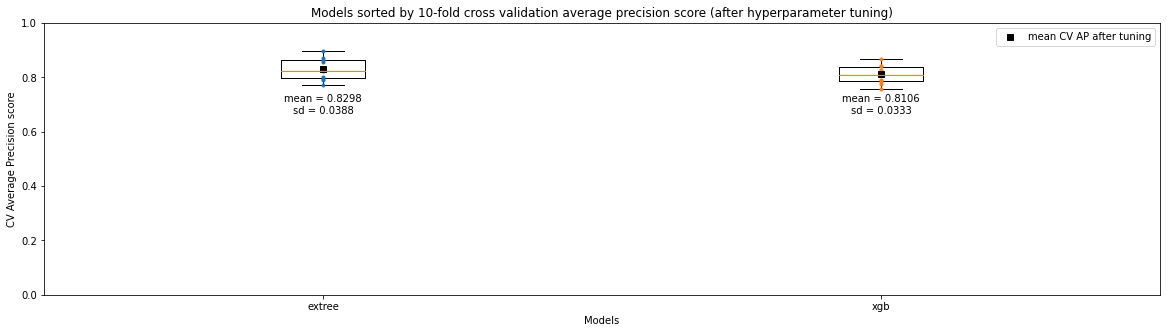

In [11]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation average precision score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV Average Precision score")
plt.show()

## Test set

In [12]:
test_set = pd.read_pickle("kaggle_creditcard_test.pkl")
# make a copy and split X and y
X_test = test_set.drop(columns = "Class").reset_index(drop = True).copy(deep = True)
y_test = test_set[["Class"]].values.reshape(-1,)

In [13]:
X_test.shape

(56962, 29)

## Pick best model and ensemble model

In [34]:
best_model = tuned_models['extree'].best_estimator_

In [35]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('myminmaxscaler',
                                                                   MyMinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe99082e0d0>)],
                                   verbose_feature_names_out=False)),
                ('selectfrommodel',
                 SelectFromModel(estimator=SGDClassifier(loss='log',
                                                         penalty='l1',
                                                         random_state=42),
                                 threshold=0.07931909113857061)),
                ('extree',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=73,
                                      min_samples_leaf=2, random_state=42))])

In [43]:
# specify regex pattern to load ensemble model
match_pattern = '_AP_Adaboost_extree_class_balanced_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
file = [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x][0]

ensemble_model = load(file)

In [69]:
ensemble_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('myminmaxscaler',
                                                                   MyMinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe9856b1ad0>)],
                                   verbose_feature_names_out=False)),
                ('selectfrommodel',
                 SelectFromModel(estimator=SGDClassifier(loss='log',
                                                         penalty='l1',
                                                         random_state=42))),
                ('Adaboost',
                 AdaBoostClassifier(base_estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                        max_depth=73,
                                                                        min_samples_leaf=2,
                                                                        random_state=42),
                                    random_state=42))])

## Predicted Probabilities

In [44]:
# prediction
y_probs = ensemble_model.predict_proba(X_test)[:,1]

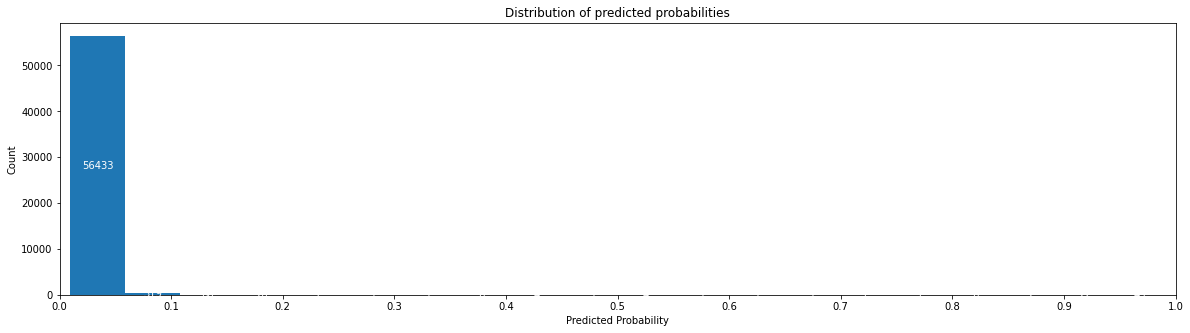

In [45]:
fig, ax = plt.subplots(1,1)
ax.hist(y_probs, bins = 20)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.0f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

# Performance evaluation

## Precision-Recall curve
- Prefer precision-recall over ROC curve
- Recall > Precision
  - False alarm is better than failing to flag a fraudulent case

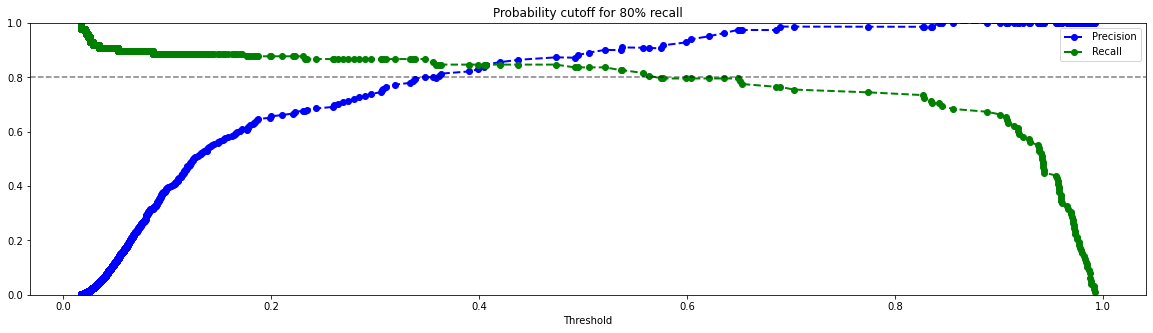

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.axhline(0.8, ls='--', c='k', alpha=0.5)
plt.title("Probability cutoff for 80% recall")
plt.legend()
plt.show()

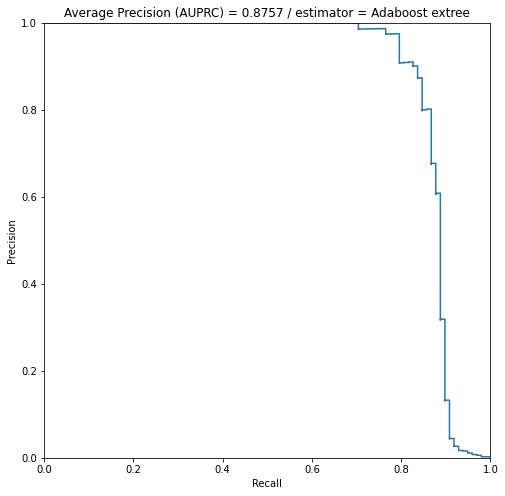

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot(ax=ax)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"Average Precision (AUPRC) = {average_precision_score(y_test, y_probs):0.4f} / estimator = {ensemble_model.steps[-1][0]} {best_model.steps[-1][0]}")
plt.show()

## Average Precision
- Average precision = area under precision-recall curve
  - [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

In [51]:
CV_model = tuned_models[best_model.steps[-1][0]]
cv_result = pd.DataFrame(CV_model.cv_results_)
cv_AP_colindex = [i for i, x in enumerate(cv_result.columns.values) if re.search('split\w+_test_score', x) is not None]
best_CV_AP = pd.DataFrame(CV_model.cv_results_).iloc[CV_model.best_index_,cv_AP_colindex].values

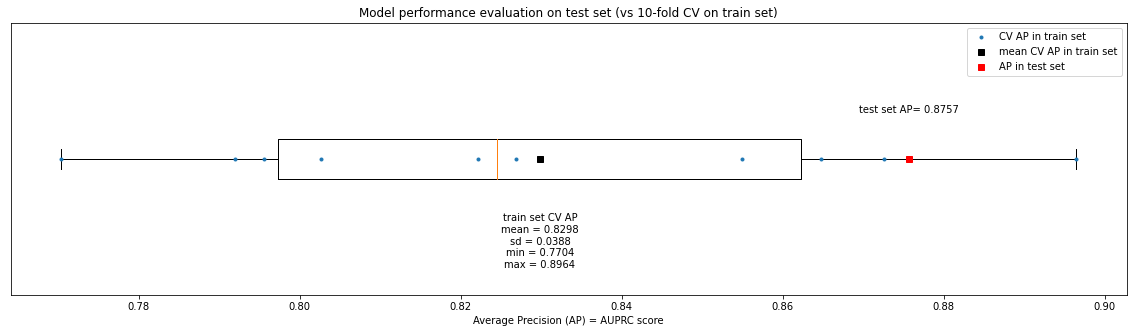

In [52]:
# plot CV AP scores on train set
plt.boxplot(best_CV_AP, labels = [""], vert=False)
plt.plot(best_CV_AP, [1]*len(best_CV_AP), ".", label='CV AP in train set')
plt.annotate(f"train set CV AP\n" + 
             f"mean = {np.mean(best_CV_AP):0.4f}\n" + 
             f"sd = {np.std(best_CV_AP):0.4f}\n" + 
             f"min = {np.min(best_CV_AP):0.4f}\n" + 
             f"max = {np.max(best_CV_AP):0.4f}",
             (np.mean(best_CV_AP), 0.8), 
              ha = 'center', va = 'top')
plt.plot(np.mean(best_CV_AP), [1], "ks", label = 'mean CV AP in train set')

# compare with AP score on test set
test_AP = average_precision_score(y_test, y_probs)
plt.plot(test_AP, [1], "rs", label = 'AP in test set')
plt.annotate(f"test set AP= {test_AP:0.4f}",(test_AP, 1.2), 
              ha = 'center', va = 'top')

plt.legend()
plt.title(f"Model performance evaluation on test set (vs 10-fold CV on train set)")
plt.xlabel("Average Precision (AP) = AUPRC score")
# plt.xlim(0.5,1)
plt.ylabel("")
plt.yticks([])
plt.show()

## Lift and gain chart

In [53]:
temp_df = pd.DataFrame({
    'y': y_test,
    'prob': y_probs
})
temp_df.sort_values('prob', ascending=False, inplace=True)
temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])

In [54]:
lift_n_gain = temp_df.groupby('decile').agg({'y': ['sum']}).sort_index(ascending=False)
lift_n_gain.columns = ['sum_of_positive_cases_identified']
lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / 10)

In [55]:
lift_n_gain

,sum_of_positive_cases_identified,gain,lift
decile,,,
1,92,0.938776,9.387755
2,2,0.959184,4.795918
3,2,0.979592,3.265306
4,0,0.979592,2.448980
5,0,0.979592,1.959184
6,0,0.979592,1.632653
7,0,0.979592,1.399417
8,2,1.000000,1.250000
9,0,1.000000,1.111111


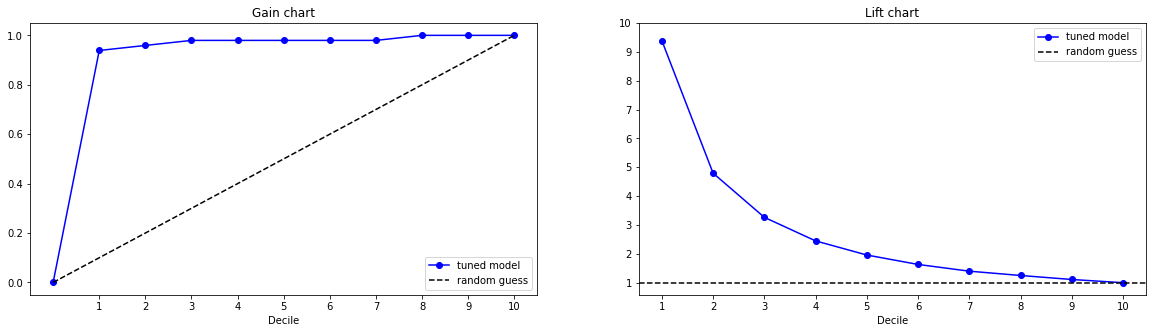

In [63]:
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(0,11,1), [0] + list(lift_n_gain['gain'].values), 'bo-', label = 'tuned model')
axes[0].plot(np.arange(0,11,1), np.arange(0,11,1) / 10, 'k--', label = 'random guess')
axes[1].plot(np.arange(1,11,1), lift_n_gain['lift'].values, 'bo-', label = 'tuned model')
axes[1].axhline(1, color = 'k', linestyle='--', label = 'random guess')
axes[0].set_title('Gain chart')
axes[1].set_title('Lift chart')
for ax in axes:
  ax.set_xticks(np.arange(1,11,1))
  ax.set_xlabel("Decile")
  ax.legend()
axes[1].set_yticks(np.arange(1,11,1))
plt.show()

## Confusion matrix

In [64]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [65]:
# to achieve a recall of 80% or more
recall_pct = 0.8

In [66]:
idx_for_chosen_recall = (recalls >= recall_pct).argmin()
chosen_threshold = thresholds[idx_for_chosen_recall]
y_predict = (best_model.predict_proba(X_test)[:,1] >= chosen_threshold)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.81      0.85        98

    accuracy                           1.00     56962
   macro avg       0.95      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [67]:
confusion_matrix(y_test, y_predict)

array([[56855,     9],
       [   19,    79]])

## ROC curve and AUC score
- ROC AUC score is high but it is overly optimistic given it replaces precision in precision-recall curve with False Positive Rate
- With class imbalance in our dataset, the inclusion of True Negatives in ROC AUC score does not give us an accurate picture of our model's ability to predict the rare positive class

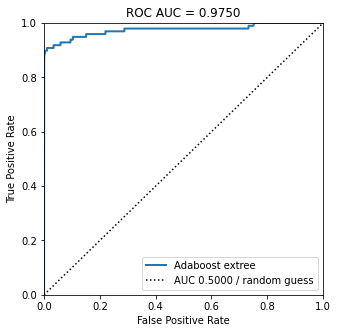

In [68]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth = 2, label = f"{ensemble_model.steps[-1][0]} {best_model.steps[-1][0]}")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"ROC AUC = {roc_auc_score(y_test, y_probs):0.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()